# Computer Vision: Image Classification

The first step to train a model for image recognition is finding images that belong to the desired class (or classes).


### ImageNet

This dataset is publicly available which the goal of promoting the development of computer vision methods. ImageNet currently has 14,197,122 images with 21841 synsets indexed (see [Imagenet](http://www.image-net.org/)).

ImageNet aims to provide on average 1k images to illustrate each one of their 100k synsets, the majority of the synsets are nouns (80.000+). The **synsets** (synonym sets) come from WordNet which is a large lexical database of English. Nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (synsets), each expressing a distinct concept.

Check more [information about ImageNet](http://www.image-net.org/about-overview).

Check more [information about WordNet](https://wordnet.princeton.edu/).
These useful classified images can be obtained using Python.

We will use for this task the **ImageNet** dataset. This is the dataset of the annual ImageNet Large Scale Visual Recognition Challenge (ILSVRC) which is a popular challenge that has brought many important innovations. 

Typical challenges performed in this dataset include:

- Image classification: Predict the classes of objects present.
- Object localization: Image classification (and draw a bounding box around one example of each object present).
- Object detection: Image classification (and draw a bounding box around each object present).
- Labeling videos.

During the first five years the pace of improvements have been dramatic, with great success using CNNs and the papers published have become a must read.

<img src="./fig/ILSVRC_improvements.png" alt="RGB explination" width="500"/>


Some of the techniques applied to improve the accuracy of the predictions include:

#### Basics:
* CNNs: Convolutional Neural Networks. It has been the technique with greater success in the last years
* ReLUS: Neurons with nonlinearity as Rectified Linear Units as they train faster than for example tanh units and they do not require input normalization to prevent saturation, although local normalization still helps generalization. Response normalization helps to reduce the final error.

#### Reducing Overfitting:
* Data Augmentation: 
    - Applying transformations (translation, rotations, zooming...) having the dataset multiplied by factors of 2048.
    - PCA performed on the RGB values, altering the intensities of the channels and adding to each image multiples of the principal componenets found with magnitues proportional to the corresponding eigenvalues itmes a random variables (from a Gaussian with mean 0 and st dev 01)
* Dropout: Combining predictions of many models is very effective to reduce errors but it's way too expensive for big neural networks that take days to train. Dropouts sets to zero the output of each hidden node with a probability of 0.5 and this way the drop out neurons do not contribute to the forward pass nor they participate on the back-propagation. So every time the NN presents a different architecture but all of them share weights. This technique reduces co-adaptations of neurons as they cannot rely on the presence of other particular neurons and they are forced to learn more robust features.

#### Some Details extracted from the papers:
- Stochastic gradient descent for training with batches of 128, momentum of 0.9 and weight decay of 0.0005 which was not merely a regularizer but it reduces as well the training error.
- The initialization was done with a Gaussian distribution with st. dev. 0.01
- The learning rate at 0.01 and reduced three times prior to termination.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,sklearn,tensorflow -g

import os
import sys
from time import time
import pickle
import argparse
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import watermark

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, classification_report
from sklearn.metrics import accuracy_score, recall_score, f1_score
import itertools

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

CPython 3.7.3
IPython 7.8.0

numpy 1.17.3
pandas 0.25.1
sklearn 0.21.3
tensorflow 2.0.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.0.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
Git hash   : f3c995c9d822165b49d9b7e03fe589c87cd3cd81


In [45]:
sys.path.append(os.pardir)
from src.cv_tools import display_features

1. **Introduction**
<br>

2. **Data preparation**
    - 2.1 Load data
    - 2.2 Check for null and missing values
    - 2.3 Normalization
    - 2.4 Reshape
    - 2.5 Label encoding
    - 2.6 Split training and valdiation set


3. **CNN**
    - 3.1 Define the model
    - 3.2 Set the optimizer and annealer
    - 3.3 Data augmentation


4. **Model Evaluation**
    - 4.1 Training and validation curves
    - 4.2 Confusion matrix


5. **Prediction**
    - 5.1 Predict samples

## 1. Introduction

This is a 5 layers Sequential CNN build with **Keras API** and trained on MNIST dataset.

The model achieves a very high accuracy (99.52%) with this CNN trained in 1h25min on a laptop (MacBook Pro Intel Core i9). If you have a GPU at hand you can use tensorflow-gpu with keras. Computation will be much much faster!!!

Initially the number of epochs 3 but to achive the highest accurary you can set it to 30 epochs.

## 2. Data Preparation
### 2.1 Load data

The data is separated between the train and the test set.

In [2]:
df_tr = pd.read_csv("./data/mnist/train.csv")
df_te = pd.read_csv("./data/mnist/test.csv")

Count per category:
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


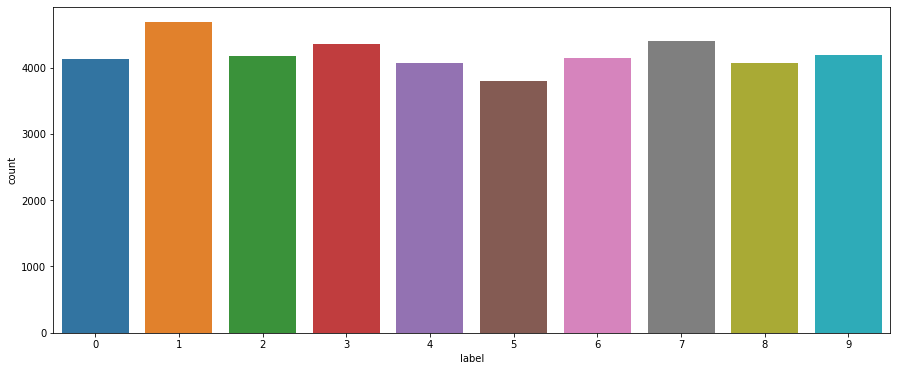

In [3]:
Y_tr = df_tr["label"]

# Drop 'label' column
X_tr = df_tr.drop(labels = ["label"], axis=1) 

# free space
del df_tr

plt.figure(figsize=(15, 6))
g = sns.countplot(Y_tr)

print(f"Count per category:\n{Y_tr.value_counts()}")

In [4]:
count_mean = Y_tr.value_counts().mean()
upper_lvl = 100 * (Y_tr.value_counts().max() - count_mean)/count_mean
lower_lvl = 100 * (Y_tr.value_counts().min() - count_mean)/count_mean
print(f"Difference in the upper range: {upper_lvl:.1f}")
print(f"Difference in the lower range: {lower_lvl:.1f}")

Difference in the upper range: 11.5
Difference in the lower range: -9.6


The difference in the counts is around +/- 10% so in this case we can consider that the distrubution is ok.

It's important to verify that we have a nice distribution of cases across all the categories to avoid having a model trained mainly in one category. If that happens the model will likely perform poorly in the classes with fewer cases in the training set.

Otherwise we may consider certain techniques to compensate/solve the issue:
- Stratified sampling
- Selected metrics: Precision@Recall=x or FPR@Recall=x  or  Recall@Precision=x
- Cost-sensitive learning
- SMOTE and ROSE algorithms. SMOTE effectively uses a k-nearest neighbours approach to exclude members of the majority class while in a similar way creating synthetic examples of a minority class. ROSE tries to create estimates of the underlying distributions of the two classes using a smoothed bootstrap approach and sample them.

### 2.2 Check for null and missing values

In [5]:
# Check the data
X_tr.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
df_te.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In this case we don't have missing values in the train nor in the test dataset. Otherwise we may have to drop the entries that don't help to train our model.

### 2.3 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences.

This helps as well to achieve a faster convergence ([0..1] data vs. [0..255]).

In [7]:
# Normalize the data
X_tr = X_tr / 255.0
df_te = df_te / 255.0

### 2.4 Reshape

In [8]:
# Reshape image from row with 784 values to 3 dimensions (height = 28px, width = 28px , canal = 1)
X_tr = X_tr.values.reshape(-1, 28, 28, 1)
df_te = df_te.values.reshape(-1, 28, 28, 1)

Train and test images (28px x 28px) has been stock into pandas as a matrix where we have 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it uses only one channel. For RGB images there are 3 channels so we would have reshaped 784px vectors to 28x28x3 3D matrices.

### 2.5 Label encoding

In [9]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_tr = to_categorical(Y_tr, num_classes=10)

### 2.6 Split training and valdiation set

In [10]:
# Set the random seed
random_seed = 42

In [11]:
# Split the train and the validation set for the fitting
X_tr, X_val, Y_tr, Y_val = train_test_split(X_tr, Y_tr, test_size=0.1, random_state=random_seed)

From the already split data (train and test) we retain a small fraction of the train data (10%) to become the **validation set** in which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset where a simple random split could cause inaccurate evaluation during the validation.

To avoid that, you could use stratify=True option in train_test_split function (only for >=0.17 sklearn versions).

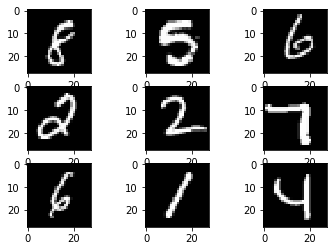

In [12]:
# Examples of the data
for i in range(9):
    plt.subplot(330 + 1 + i)                                   # subplot def
    plt.imshow(X_tr[i][:,:,0], cmap=plt.get_cmap('gray'))      # raw pixel data

It may be useful as well to understand the distribution of the gradation of the color layer that we have. Humans are limited and we see 100 levels of gradation of a single color (in this case, white/grey/black) and even fewer with the limitations of a computer display, but we may have images with up to 2^16 == 65536 levels in a 16 bit image and the CNN won't have problems seeing those differences as it takes as input floating point data.

For human purposes we may apply windowing and get 3x levels by using 3 channel image with different windows in each channel.

On the other hand this doesn't mean that we can ignore scaling entirely for the CNN as having well-scaled inputs is really important in getting good results from your NN. That means we want to see a good mix of values throughout the range of our data (e.g. something having approximately a normal or uniform distribution).

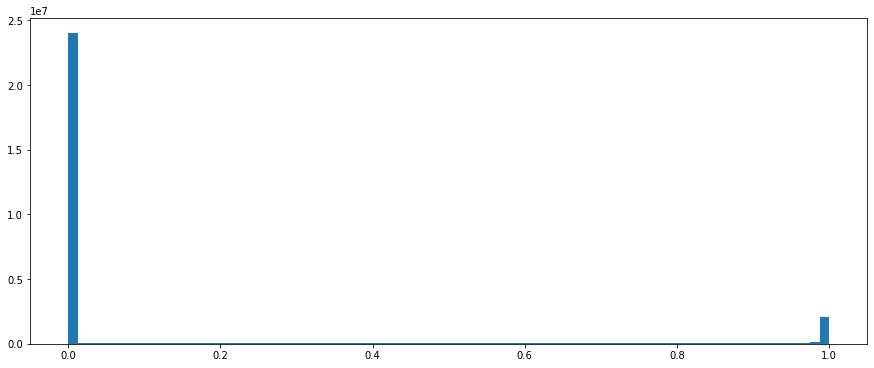

In [13]:
px = X_tr.flatten()
plt.figure(figsize=(15, 6))
plt.hist(px, bins=80);

As the graph shows, we don't have that at all.

We have a highly bimodal distribution, with lots of background pixels at around 0 and the digits at 1. But that's OK, we can normalize this using a simple scaling of the pixel values using a non-linear mapping designed to give us an equal number of pixels in each range. To do that we first split the range of pixel values into groups, such that each group has around the same number of pixels.

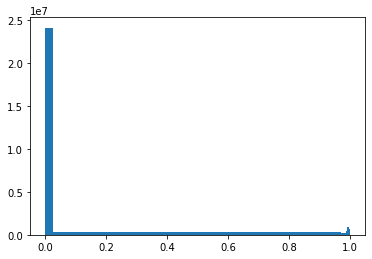

In [14]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

# Calculate the bins. In this case as most points are just zero there is not much we can do.
n, bins, patches = plt.hist(px, histedges_equalN(px, 80))

## 3. CNN
### 3.1 Define the model

In tensorflow 2.0 Keras is already included as its Sequential API is really easy to use. With the Sequential API you just have just to add one layer at a time starting from the input.

First is the **convolutional (Conv2D) layer**, a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the **pooling (MaxPool2D) layer**. This layer simply acts as a downsampling filter by looking at the 2 neighboring pixels and picking the maximal value. This technique is used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size. The highest the pooling dimension, more the downsampling is important.

Combining convolutional and pooling layers CNN are able to combine local features and learn more global features of the image.

**Dropout** is a regularization method, where a proportion of nodes in the layer are randomly set to zero with 0.5 probability for each training sample. This forces the network to learn features in a distributed way and the NN have to learn independenly from each other. This technique also improves generalization and reduces the overfitting.

**ReLU** is the rectifier, and activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The **Flatten layer** is used to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

And finally two fully-connected **(Dense) layers** which is just an Artificial Neural Networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs  the distribution of probability for each class.

In [15]:
# Set the CNN model with architechture:
#    In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()


model.add(Conv2D(filters =32, kernel_size=(5, 5), padding="Same", 
                 activation="relu", input_shape = (28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="Same",
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="Same",
                 activation ="relu"))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="Same",
                 activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))


# Combine all local features into 1D vector
model.add(Flatten())
# Classifier
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

### 3.2 Set the optimizer and annealer

Now we need to set up a **score function** a **loss function** and an **optimisation algorithm**.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the ***"categorical_crossentropy"***.

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss. RMSprop (with default values) is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [16]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [17]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, we use an **annealing method** of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, we choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [18]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
epochs = 3            # Turn epochs to 30 to get 0.9952 accuracy
batch_size = 86

### 3.3 Data augmentation

In order to **avoid overfitting** we need to expand artificially our handwritten digit dataset. We can make the existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

Some operations we can perform while keeping the same labels, include:

- Translation
- Rotation
- Zooming
- Random crops
- Grayscales
- Color jitters
- Horizontal flips
- Vertical flips

This way we can triple or more the number of training examples and create a very robust model. This is an important step as it provides a relevant improvement to the model:

- Without data augmentation: accuracy of 98.79%
- With data augmentation:  99.52% of accuracy

In [20]:
# %%time
# Without data augmentation
# trained_model_no_aug = model.fit(X_tr, Y_tr, batch_size=batch_size, epochs=epochs, 
#                                  validation_data=(X_val, Y_val), verbose=2)

<img src="./fig/CV_Classification_no_augmentaion.png" alt="RGB explination" width="800"/>

In [21]:
# With data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    featurewise_center=False,             # set input mean to 0 over the dataset
    samplewise_center=False,              # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,   # divide each input by its std
    zca_whitening=False,                  # apply ZCA whitening
    rotation_range=10,                    # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1,                     # Randomly zoom image 
    width_shift_range=0.1,                # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,               # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,                # randomly flip images
    vertical_flip=False)                  # randomly flip images

datagen.fit(X_tr)

For the data augmentation:

- Randomly rotate some training images by 10 degrees
- Randomly Zoom by 10%
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height
- Not vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

If you set the *steps_per_epoch* to fit *n_samples / batch_size*, where n_samples is the total number of training data you have (i.e. 1k) then in each epoch, each training sample is augmented only one time (therefore 1k transformed images will generated in each epoch)

In [23]:
model.load_weights('./models/mnist_CNN_model.hdf5')

In [22]:
%%time
# Fit the model
history = model.fit_generator(datagen.flow(X_tr, Y_tr, batch_size=batch_size),
                              epochs=epochs, validation_data=(X_val, Y_val),
                              verbose=2, steps_per_epoch=X_tr.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/5
439/439 - 101s - loss: 0.3979 - accuracy: 0.8707 - val_loss: 0.0644 - val_accuracy: 0.9795
Epoch 2/5
439/439 - 101s - loss: 0.1271 - accuracy: 0.9610 - val_loss: 0.0438 - val_accuracy: 0.9886
Epoch 3/5
439/439 - 103s - loss: 0.0928 - accuracy: 0.9725 - val_loss: 0.0319 - val_accuracy: 0.9900
Epoch 4/5
439/439 - 104s - loss: 0.0805 - accuracy: 0.9769 - val_loss: 0.0407 - val_accuracy: 0.9886
Epoch 5/5
439/439 - 101s - loss: 0.0722 - accuracy: 0.9793 - val_loss: 0.0276 - val_accuracy: 0.9910
CPU times: user 38min 39s, sys: 24min 12s, total: 1h 2min 52s
Wall time: 8min 30s


## 4. Model Evaluation
### 4.1 Training and validation curves

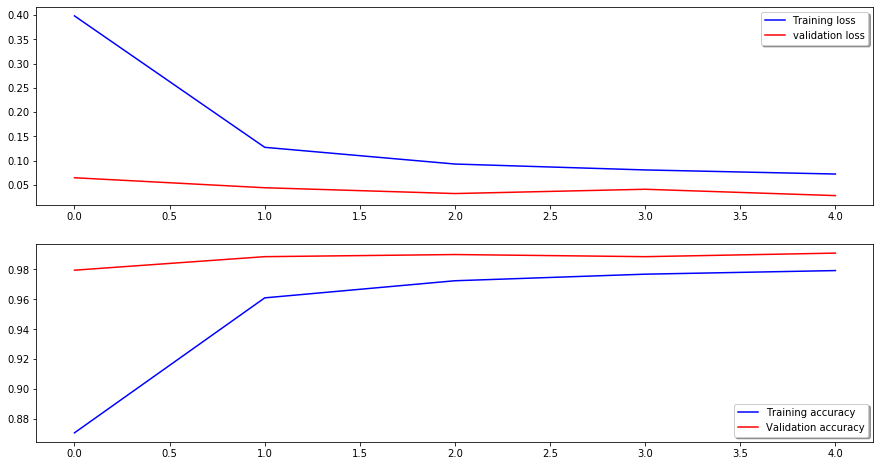

In [24]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
fig.set_figheight(8)
fig.set_figwidth(15)

The code below is for plotting loss and accuracy curves for training and validation. Below it's the training and validation curves with 30 epochs (1h25min)

<img src="./fig/CV_Classification_30_epochs_learning_curves.png" alt="RGB explination" width="800"/>

The model reaches almost 99% (98.7+%) accuracy on the validation dataset after 2 epochs. The validation accuracy is greater than the training accuracy almost every time during the training. That means that our model doesn't overfit the training set.

### 4.2 Confusion matrix

The confusion matrix is very helpfull to see the model drawbacks.

This is the confusion matrix on the validation results.

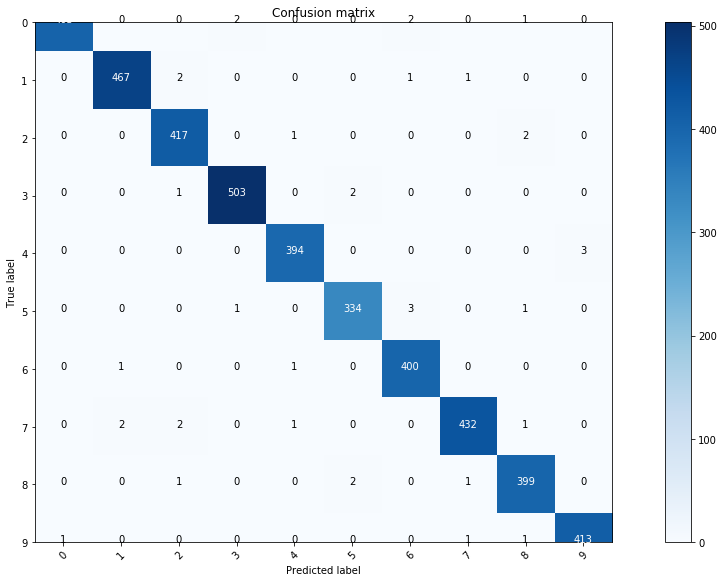

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
plt.figure(figsize=(15, 8))
plot_confusion_matrix(confusion_mtx, classes=range(10))

We can see that the CNN performs very well on all digits with few errors considering the size of the validation set (4200 images).

However, it seems that our CNN has some troubles with the 4s and some are misclassified as 9s.

Let's investigate for errors.

We want to see the most important errors. For that purpose we select the biggest differences between the probabilities of the real label and the predicted labels in the results.

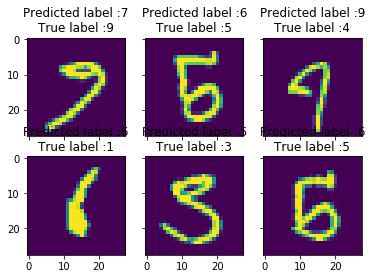

In [26]:
# Display error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28, 28)))
            ax[row,col].set_title(
                f"Predicted label :{pred_errors[error]}\nTrue label :{obs_errors[error]}")
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

The most important errors are also the most interesting ones.

It is clear that for the selected cases the model is not doing anything strange, in fact the errors are quite human as many people will find difficult to read these digits. We see that the first four it is very close to 9 as well as the 0, having a mark on top which is very misleading, gets confused with a 6.

In [37]:
Y_pred = model.predict(X_val)
Y_pred_class = np.argmax(Y_pred, axis=1)
Y_val_class = np.argmax(Y_val, axis=1) 
print(f'Accuracy: \t{accuracy_score(Y_val_class, Y_pred_class):.3}')
print(f'Precision: \t{[round(k, 3) for k in precision_score(Y_val_class, Y_pred_class, average=None)]}')
print(f'Recall: \t{[round(k, 3) for k in recall_score(Y_val_class, Y_pred_class, average=None)]}')
print(f'F1 score: \t{[round(k, 3) for k in f1_score(Y_val_class, Y_pred_class, average=None)]}')

# Or all together....
print(f'\nclasification report:\n {classification_report(Y_val_class, Y_pred_class)}')

Accuracy: 	0.991
Precision: 	[0.998, 0.994, 0.986, 0.994, 0.992, 0.988, 0.985, 0.993, 0.985, 0.993]
Recall: 	[0.988, 0.992, 0.993, 0.994, 0.992, 0.985, 0.995, 0.986, 0.99, 0.993]
F1 score: 	[0.993, 0.993, 0.989, 0.994, 0.992, 0.987, 0.99, 0.99, 0.988, 0.993]

clasification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       408
           1       0.99      0.99      0.99       471
           2       0.99      0.99      0.99       420
           3       0.99      0.99      0.99       506
           4       0.99      0.99      0.99       397
           5       0.99      0.99      0.99       339
           6       0.99      1.00      0.99       402
           7       0.99      0.99      0.99       438
           8       0.99      0.99      0.99       403
           9       0.99      0.99      0.99       416

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg 

## 5. Prediction
### 5.1 Predict samples

In [27]:
# predict results
results = model.predict(df_te)

# select the indix with the maximum probability
results = np.argmax(results, axis = 1)

results = pd.Series(results, name="Label")

In [28]:
submission = pd.concat([pd.Series(range(1,28001),name="ImageId"), results], axis=1)

# submission.to_csv("cnn_mnist_datagen.csv", index=False)

## 6. Feature Extraction

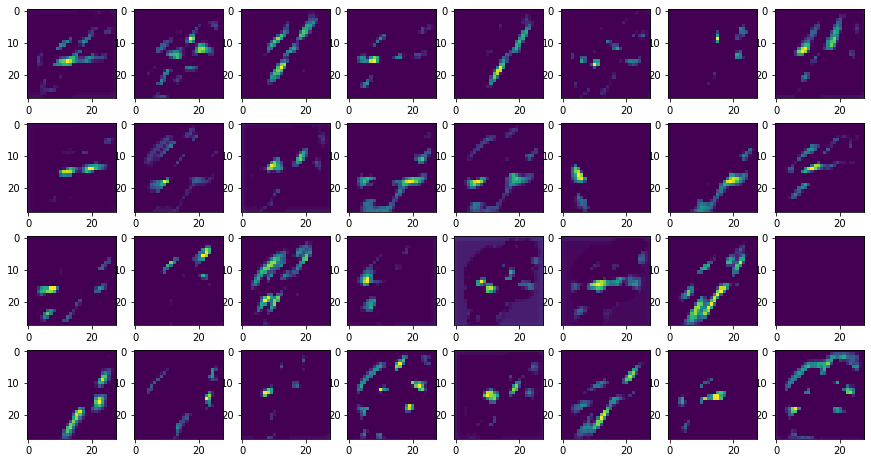

In [69]:
output_layers = [layer.output for layer in model.layers if not layer.name.startswith('input')]
feature_model = Model(inputs=model.input, outputs=output_layers)
features = feature_model.predict(X_val[100].reshape(1, 28, 28, 1))

display_features(features, 1, 8)

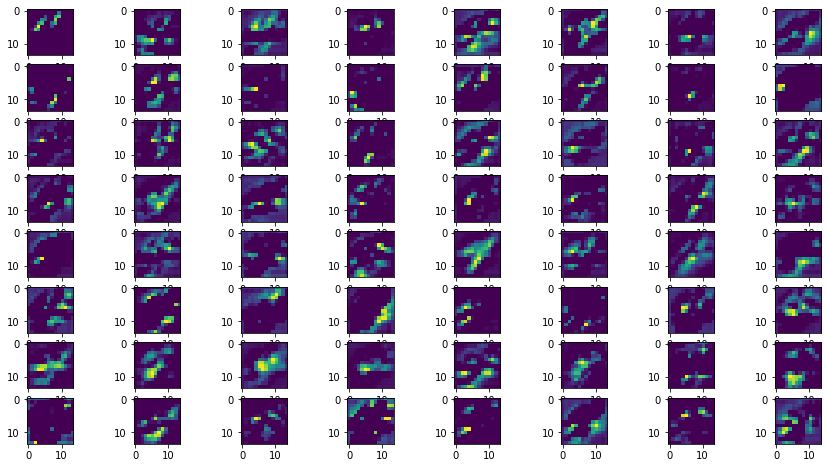

In [70]:
display_features(features, 4, 8)

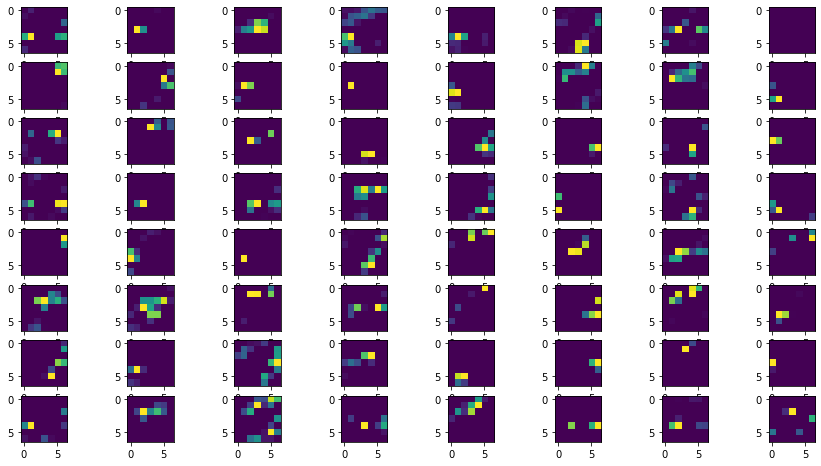

In [68]:
display_features(features, 7, 8)

[1] [ImageNet: A Large-Scale Hierarchical Image Database](https://ieeexplore.ieee.org/document/5206848), 2009.

[2] [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks), 2012.

[3] [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901), 2013.

[4] [Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842), 2014.

[5] [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556), 2015.

[6] [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), 2015.

[7] [ImageNet Large Scale Visual Recognition Challenge](https://link.springer.com/article/10.1007/s11263-015-0816-y), 2015.

[8] [Image Classification transfer learning with Inception v3](https://codelabs.developers.google.com/codelabs/cpb102-txf-learning/index.html#0)

[9] [Advanced Guide to Inception v3 on Cloud TPU](https://cloud.google.com/tpu/docs/inception-v3-advanced)